In [1]:
# Import dependencies
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from scipy.stats import sem
import plotly.express as px

In [2]:
# Sample versus population example fuel economy
nfl_youtubes = pd.read_csv('/Users/jessmroczek/Documents/DA_Bootcamp/Homework Files/Project 3/NFL_ads/youtube.csv')
# First overview the data set - how many factors, etc.
print(nfl_youtubes.head())

   year      brand                          superbowl_ads_dot_com_url  \
0  2018     Toyota        https://superbowl-ads.com/good-odds-toyota/   
1  2020  Bud Light  https://superbowl-ads.com/2020-bud-light-seltz...   
2  2006  Bud Light  https://superbowl-ads.com/2006-bud-light-bear-...   
3  2018    Hynudai  https://superbowl-ads.com/hope-detector-nfl-su...   
4  2003  Bud Light  https://superbowl-ads.com/2003-bud-light-hermi...   

                                   youtube_url  funny  show_product_quickly  \
0  https://www.youtube.com/watch?v=zeBZvwYQ-hA  False                 False   
1  https://www.youtube.com/watch?v=nbbp0VW7z8w   True                  True   
2  https://www.youtube.com/watch?v=yk0MQD5YgV8   True                 False   
3  https://www.youtube.com/watch?v=lNPccrGk77A  False                  True   
4  https://www.youtube.com/watch?v=ovQYgnXHooY   True                  True   

   patriotic  celebrity  danger  animals  ...  like_count dislike_count  \
0      Fals

In [4]:
column_types = nfl_youtubes.dtypes
print(column_types)

year                           int64
brand                         object
superbowl_ads_dot_com_url     object
youtube_url                   object
funny                           bool
show_product_quickly            bool
patriotic                       bool
celebrity                       bool
danger                          bool
animals                         bool
use_sex                         bool
id                            object
kind                          object
etag                          object
view_count                   float64
like_count                   float64
dislike_count                float64
favorite_count               float64
comment_count                float64
published_at                  object
title                         object
description                   object
thumbnail                     object
channel_title                 object
category_id                  float64
dtype: object


In [5]:
# Define a mapping dictionary for brand types
brand_type_mapping = {
    'Bud Light': 'Alcohol',
    'Budweiser': 'Alcohol',
    'Doritos': 'Food & Beverage',
    'Pepsi': 'Food & Beverage',
    'Coca-Cola': 'Food & Beverage',
    'Toyota': 'Automobile',
    'Chevrolet': 'Automobile',
    'E-Trade': 'Investment' 
    # Add more mappings as needed
}


In [6]:
# Map brand types to the 'brand' column
nfl_youtubes['brand_type'] = nfl_youtubes['brand'].map(brand_type_mapping)

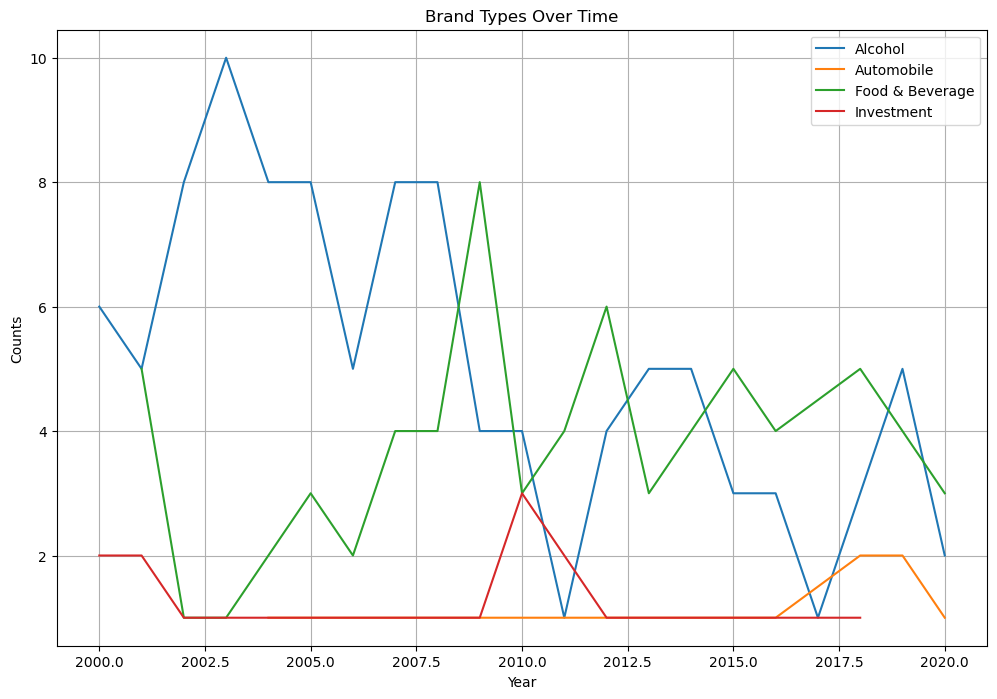

In [7]:
# Now you can proceed with creating the chart as before

# Group by brand type and year, and aggregate the data as needed
brand_type_counts = nfl_youtubes.groupby(['brand_type', 'year']).size().reset_index(name='counts')

# Round 'year' values to the nearest integer
nfl_youtubes['year'] = nfl_youtubes['year'].round().astype(object)

# Plotting
plt.figure(figsize=(12, 8))

# Iterate over unique brand types
for brand_type in brand_type_counts['brand_type'].unique():
    data = brand_type_counts[brand_type_counts['brand_type'] == brand_type]
    plt.plot(data['year'], data['counts'], label=brand_type)

plt.title('Brand Types Over Time')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Selecting specific columns
superbowl_viz = nfl_youtubes[['year', 'brand', 'animals', 'celebrity', 'use_sex', 
                            'funny', 'show_product_quickly', 'patriotic', 'danger']]

# Reshaping the DataFrame
superbowl_viz = superbowl_viz.melt(id_vars=['year', 'brand'], 
                                    var_name='ad_type', 
                                    value_name='have')

# Filtering rows where 'have' is TRUE
superbowl_viz = superbowl_viz[superbowl_viz['have']]

# Counting occurrences
superbowl_viz = superbowl_viz.groupby(['brand', 'year', 'ad_type']).size().reset_index(name='ads')

# Replacing 'Hynudai' with 'Hyundai'
superbowl_viz['brand'] = np.where(superbowl_viz['brand'] == 'Hynudai', 'Hyundai', superbowl_viz['brand'])

# Creating a new column 'category'
superbowl_viz['category'] = np.select(
    [
        (superbowl_viz['brand'] == 'Bud Light') | (superbowl_viz['brand'] == 'Budweiser'),
        (superbowl_viz['brand'] == 'Doritos') | (superbowl_viz['brand'] == 'Pepsi') | (superbowl_viz['brand'] == 'Coca-Cola'),
        (superbowl_viz['brand'] == 'Hyundai') | (superbowl_viz['brand'] == 'Toyota') | (superbowl_viz['brand'] == 'Kia'),
        (superbowl_viz['brand'] == 'E-Trade'),
        (superbowl_viz['brand'] == 'NFL')
    ],
    [
        'Alcohol',
        'Food & Beverage',
        'Automobile',
        'Financial Services',
        'Sports'
    ],
    default='Other'
)

# Moving columns
superbowl_viz = superbowl_viz[['year', 'category', 'brand', 'ad_type', 'ads']]

# Brand Total Labels
brand_totals = superbowl_viz[~superbowl_viz['ad_type'].isin(['celebrity', 'use_sex', 'danger', 'patriotic'])]
brand_totals = brand_totals.groupby('brand').size().reset_index(name='brand_totals')

# Plotting
plt.figure(figsize=(12, 8))

brand_order = ['Bud Light', 'Budweiser', 'Doritos', 'Pepsi', 'Coca-Cola', 
               'Hyundai', 'E-Trade', 'Toyota', 'Kia', 'NFL']

superbowl_viz['brand'] = pd.Categorical(superbowl_viz['brand'], categories=brand_order, ordered=True)

for ad_type, color in zip(['show_product_quickly', 'funny', 'animals'], ['#56B4E9', '#E69F00', '#009E73']):
    temp_df = superbowl_viz[superbowl_viz['ad_type'] == ad_type]
    plt.bar(temp_df['brand'], temp_df['ads'], label=ad_type, color=color, alpha=0.7)

for i, brand in enumerate(brand_order):
    plt.text(i, brand_totals.loc[brand_totals['brand'] == brand, 'brand_totals'].values[0], 
             str(brand_totals.loc[brand_totals['brand'] == brand, 'brand_totals'].values[0]), 
             ha='center', va='bottom', fontweight='bold')

plt.title('Ad Occurrences by Brand')
plt.xlabel('Brand')
plt.ylabel('Ad Occurrences')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ad Type', loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
nfl_youtubes_reduced_columns = nfl_youtubes[['year', 'brand'
                              ]]

In [ ]:
nfl_youtubes_reduced_columns["year"].value_counts()

In [ ]:
fig = px.bar(nfl_youtubes, x="year", y="brand", title="Long-Form Input")
fig.show()